## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

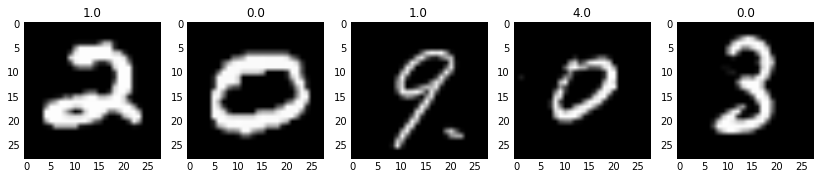

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### Идея : разбить картинку на 4 части, для каждой из частей найти гистограмму, обучить на разных частях модели, выбрать голосованием большинства моделей ответ

In [6]:
def split_to(img):
    parts = []
    parts.append(img[:, 0 : img.shape[2]//2, 0 : img.shape[2]//2])
    parts.append(img[:, 0 : img.shape[2]//2, img.shape[2]//2 :])

    parts.append(img[:, img.shape[2]//2 : , 0 : img.shape[2]//2])
    parts.append(img[:, img.shape[2]//2 :, img.shape[2]//2 :])
    return parts

In [7]:
train_parts = split_to(train_img)
test_parts = split_to(test_img)

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [8]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [10]:
train_parts_sobel_x = split_to(train_sobel_x)
train_parts_sobel_y = split_to(train_sobel_y)
test_parts_sobel_x = split_to(test_sobel_x)
test_parts_sobel_y = split_to(test_sobel_y)

## Вычисляем угол и длину вектора градиента

In [11]:
def get_part_len_and_theta(x, y):
    return cv2.cartToPolar(x, y)

In [12]:
def get_cart_polar(parts_sobel_x, parts_sobel_y):
    parts = []
    for i in range(4):
        g, theta = cv2.cartToPolar(parts_sobel_x[i], parts_sobel_y[i])
        parts.append((g, theta))
    return parts

In [13]:
train_part_sobel = get_cart_polar(train_parts_sobel_x, train_parts_sobel_y)
test_part_sobel = get_cart_polar(test_parts_sobel_x, test_parts_sobel_y)

## Вычисляем гистограммы градиентов

In [14]:
# Гистограммы вычисляются с учетом длины вектора градиента
def get_part_hist(train_img, train_g, train_theta):
    train_hist = np.zeros((len(train_img), 16))
    for i in range(len(train_img)):
        hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
        train_hist[i] = hist
    return train_hist

In [15]:
def get_hist(train_part, train_part_sobel):
    parts = []
    for i in range(4):
        part = get_part_hist(train_part[i], train_part_sobel[i][0], train_part_sobel[i][1])
        part = part / (np.linalg.norm(part, axis=1)[:, None] + 1e-26)
        parts.append(part)
    parts = np.concatenate([parts[0] , parts[1], parts[2], parts[3]], axis = 1 )
    return parts

In [16]:
train_part_hist = get_hist(train_parts, train_part_sobel)
test_part_hist = get_hist(test_parts, test_part_sobel)

## Посмотрим на части

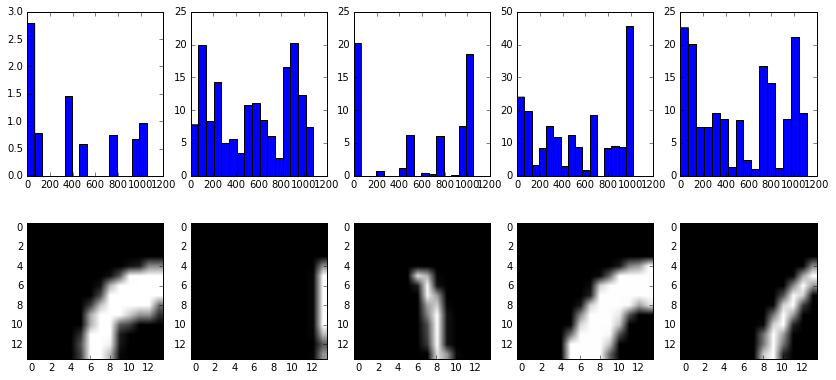

In [17]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_parts[0][:5], 1):

    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(train_parts[0][i], cmap='gray')
    
    subplot = fig.add_subplot(3, 7, i)

    plt.hist(train_part_sobel[0][0][i - 1].flatten(),
            bins=16, weights=train_part_sobel[0][1][i - 1].flatten())
    

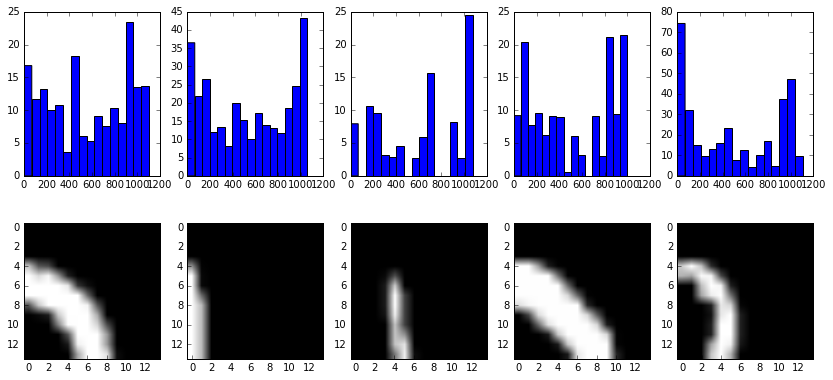

In [18]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_parts[1][:5], 1):

    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(train_parts[1][i], cmap='gray')
    
    subplot = fig.add_subplot(3, 7, i)

    plt.hist(train_part_sobel[1][0][i - 1].flatten(),
            bins=16, weights=train_part_sobel[1][1][i - 1].flatten())

## Разбиваем выборку на обучение и валидацию

In [19]:
N_split = 30000
q = 16
X_train = train_part_hist
X_test = test_part_hist
y_train = train_label

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn_top_l = KNeighborsClassifier()
knn_top_l.fit(X_train[:N_split, :q], y_train[:N_split])
pred_val_top_l = knn_top_l.predict(X_train[N_split:,:q])

knn_top_r = KNeighborsClassifier()
knn_top_r.fit(X_train[:N_split, q:2*q], y_train[:N_split])
pred_val_top_r = knn_top_r.predict(X_train[N_split:, q:2*q])



knn_bottom_l = KNeighborsClassifier()
knn_bottom_l.fit(X_train[:N_split, 2*q:3*q], y_train[:N_split])
pred_val_bottom_l = knn_bottom_l.predict(X_train[N_split:, 2*q:3*q])

knn_bottom_r = KNeighborsClassifier()
knn_bottom_r.fit(X_train[:N_split, 3*q:], y_train[:N_split])
pred_val_bottom_r = knn_bottom_r.predict(X_train[N_split:, 3*q:])


In [21]:
from collections import Counter
pred = []
for i in range(0, len(pred_val_bottom_r)):
    cnt = Counter([pred_val_top_l[i], pred_val_top_r[i], pred_val_bottom_l[i], pred_val_bottom_r[i]])
    pred.append(max(cnt, key=cnt.get))

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(train_label[N_split:], pred))

Accuracy: 0.78925


In [23]:
pred_test_top_l = knn_top_l.predict(X_test[:, :q])

pred_test_top_r = knn_top_r.predict(X_test[:, q:2*q])

pred_test_bottom_l = knn_bottom_l.predict(X_test[:, 2*q : 3*q])

pred_test_bottom_r = knn_bottom_r.predict(X_test[:, 3*q:])

In [24]:
pred_test = []
for i in range(0, len(pred_test_top_l)):
    cnt = Counter([pred_test_top_l[i], pred_test_top_r[i], pred_test_bottom_l[i], pred_test_bottom_r[i]])
    pred_test.append(max(cnt, key=cnt.get))

In [25]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

![alt text](result/res_1_lab.png "Title")